# __Set Up & Import__

## Import Necessary Library

In [7]:
# %pip install opencv-python
# %pip install mediapipe
# %pip install plotly
# %pip install pandas
# %pip install imageio
%pip install Pillow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import plotly.express as px
import ast
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation
import imageio
from PIL import Image, ImageDraw, ImageFont
import time

/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Set Color Class [ _Not Important_ ]

In [30]:
class color:
   PINK = '\033[95m'
   CYAN = '\033[96m'
   PURPLE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Set Up Detection Model

In [24]:
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1
)

# Initializing the drawing utils for drawing the landmarks on image
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1729530216.929231   12580 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M2


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729530217.070890   73933 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729530217.090482   73934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729530217.093800   73930 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729530217.094060   73929 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729530217.094062   73934 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729530217.097779   73

# __Define Needed Function__

## Extract & Structerize Position From Each Part

In [38]:
def extract_data(hand_pos):
    right, left, body, i = dict(), dict(), dict(), 0
    if hand_pos[0] != None:
        for data in hand_pos[0].landmark:
            right['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        right = None

    if hand_pos[1] != None:
        for data in hand_pos[1].landmark:
            left['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        left = None

    if hand_pos[2] != None:
        for data in hand_pos[2].landmark:
            body['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        body = None

    hand_pos = {'Right': right, 'Left': left, 'Body': body}
    hand_pos_df = pd.DataFrame(hand_pos).T
    
    return hand_pos_df

## Main Function

In [21]:
def operate(mp_holistic,holistic_model, mp_drawing, file,folder_path):    
    vid = cv2.VideoCapture(file)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper])
        hand_pos_df.to_csv(folder_path+'/Frame_'+str(total_capture-1)+'.csv')
        print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    vid.release()
    cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

## Graph Drawing

In [22]:
edges = {
        "left_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "right_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "pose": [
            (8, 6), (6, 5), (6, 4), (4, 0), (0, 1), (1, 2), (2, 3), (3, 7),
            (10, 9), (11, 12), (11, 13), (11, 23), (13, 15), (15, 21), (15, 17),
            (15, 19), (17, 19), (12, 14), (12, 24), (14, 16), (16, 22), (16, 20),
            (16, 18), (18, 20), (23, 24)
        ],
    }

In [23]:
def draw_edges(ax, points, edges):
    
    for edge in edges:
        start, end = edge

        if start < len(points) and end < len(points):
            x_values = [points[start][0], points[end][0]]
            y_values = [points[start][1], points[end][1]]
            ax.plot(x_values, y_values, 'k-')

In [24]:
def graph_drawer(frame ,edges):
    # Extract data from the CSV file
    lst_frame_right = frame.iloc[0][1:].to_frame().dropna().values
    lst_frame_left = frame.iloc[1][1:].to_frame().dropna().values
    lst_frame_body = frame.iloc[2][1:].to_frame().dropna().values

    # Convert string representations of lists to actual lists
    lst_frame_right = [ast.literal_eval(lst_frame_right[i][0]) for i in range(len(lst_frame_right))]
    lst_frame_left = [ast.literal_eval(lst_frame_left[i][0]) for i in range(len(lst_frame_left))]
    lst_frame_body = [ast.literal_eval(lst_frame_body[i][0]) for i in range(len(lst_frame_body))]

    # Extract x and y coordinates
    right_x = [lst_frame_right[i][0] for i in range(len(lst_frame_right))]
    right_y = [lst_frame_right[i][1] for i in range(len(lst_frame_right))]
    left_x = [lst_frame_left[i][0] for i in range(len(lst_frame_left))]
    left_y = [lst_frame_left[i][1] for i in range(len(lst_frame_left))]
    body_x = [lst_frame_body[i][0] for i in range(len(lst_frame_body))]
    body_y = [lst_frame_body[i][1] for i in range(len(lst_frame_body))]

    # Create the plot
    _, axis = plt.subplots(2, 2, constrained_layout=True)
    axis[0, 0].scatter(right_x, right_y)
    axis[0, 0].set_title("Right hand")

    axis[0, 1].scatter(left_x, left_y)
    axis[0, 1].set_title("Left hand")

    axis[1, 0].scatter(body_x, body_y)
    axis[1, 0].set_title("Body")

    axis[1, 1].scatter(right_x, right_y)
    axis[1, 1].scatter(left_x, left_y)
    axis[1, 1].scatter(body_x, body_y)
    axis[1, 1].set_title("All")

    # Draw edges for right hand, left hand, body, entire body
    draw_edges(axis[0, 0], lst_frame_right, edges["right_hand"])
    draw_edges(axis[0, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 0], lst_frame_body, edges["pose"])
    draw_edges(axis[1, 1], lst_frame_right, edges["right_hand"])
    draw_edges(axis[1, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 1], lst_frame_body, edges["pose"])


    # axis[0,0].yaxis.set_inverted(True)
    # axis[0,1].yaxis.set_inverted(True)
    # axis[1,0].yaxis.set_inverted(True)
    # axis[1,1].yaxis.set_inverted(True)

    # Invert 
    for ax in axis.flatten():
        ax.yaxis.set_inverted(True)
    plt.show()

In [25]:
def graph_drawer_animate(frame ,edges,file):
    # Extract data from the CSV file
    lst_frame_right = frame.iloc[0][1:].to_frame().dropna().values
    lst_frame_left = frame.iloc[1][1:].to_frame().dropna().values
    lst_frame_body = frame.iloc[2][1:].to_frame().dropna().values

    # Convert string representations of lists to actual lists
    lst_frame_right = [ast.literal_eval(lst_frame_right[i][0]) for i in range(len(lst_frame_right))]
    lst_frame_left = [ast.literal_eval(lst_frame_left[i][0]) for i in range(len(lst_frame_left))]
    lst_frame_body = [ast.literal_eval(lst_frame_body[i][0]) for i in range(len(lst_frame_body))]

    # Extract x and y coordinates
    right_x = [lst_frame_right[i][0] for i in range(len(lst_frame_right))]
    right_y = [lst_frame_right[i][1] for i in range(len(lst_frame_right))]
    left_x = [lst_frame_left[i][0] for i in range(len(lst_frame_left))]
    left_y = [lst_frame_left[i][1] for i in range(len(lst_frame_left))]
    body_x = [lst_frame_body[i][0] for i in range(len(lst_frame_body))]
    body_y = [lst_frame_body[i][1] for i in range(len(lst_frame_body))]

    # Create the plot
    _, axis = plt.subplots(2, 2, constrained_layout=True)
    axis[0, 0].scatter(right_x, right_y)
    axis[0, 0].set_title("Right hand")

    axis[0, 1].scatter(left_x, left_y)
    axis[0, 1].set_title("Left hand")

    axis[1, 0].scatter(body_x, body_y)
    axis[1, 0].set_title("Body")

    axis[1, 1].scatter(right_x, right_y)
    axis[1, 1].scatter(left_x, left_y)
    axis[1, 1].scatter(body_x, body_y)
    axis[1, 1].set_title("All")

    # Draw edges for right hand, left hand, body, entire body
    draw_edges(axis[0, 0], lst_frame_right, edges["right_hand"])
    draw_edges(axis[0, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 0], lst_frame_body, edges["pose"])
    draw_edges(axis[1, 1], lst_frame_right, edges["right_hand"])
    draw_edges(axis[1, 1], lst_frame_left, edges["left_hand"])
    draw_edges(axis[1, 1], lst_frame_body, edges["pose"])


    # axis[0,0].yaxis.set_inverted(True)
    # axis[0,1].yaxis.set_inverted(True)
    # axis[1,0].yaxis.set_inverted(True)
    # axis[1,1].yaxis.set_inverted(True)

    # Invert 
    for ax in axis.flatten():
        ax.yaxis.set_inverted(True)
    # plt.show()

    img_path = f'plot_img/{file}_img.png'
    try:
        plt.savefig(img_path)
        plt.close()
        return img_path
    except Exception as e:
        print(f"Error saving image: {e}")
        return None

In [26]:
from IPython.display import Image, display 
def animation_plot(frame_folder, edges, gif_name='animation.gif'):
    files = os.listdir(frame_folder)
    sorted_files = sorted(files, key=lambda x: int(x.split('.')[0].split('_')[1]))

    # List to hold the file names of each frame
    frame_images = []

    for file in sorted_files:
        frame = pd.read_csv(os.path.join(frame_folder, file))
        img_path = graph_drawer_animate(frame, edges,file)
        if img_path is None:
            print(f"Failed to generate frame for file: {file}")
            continue  # Skip this iteration if img_path is None
        frame_images.append(img_path)

    # Create a GIF from the images
    if frame_images:  # Ensure there are images to create a GIF
        with imageio.get_writer(gif_name, mode='I', duration=0.5) as writer:
            for img_path in frame_images:
                image = imageio.imread(img_path)
                writer.append_data(image)

        print(f'GIF saved as {gif_name}')
        display(Image(filename=gif_name))
    else:
        print("No frames were generated, GIF not created.")


# __KeyPoint__

In [2]:
operate(mp_holistic,holistic_model, mp_drawing, 'hello1.mp4',folder_path='hello/1')

NameError: name 'operate' is not defined

# __Plot__

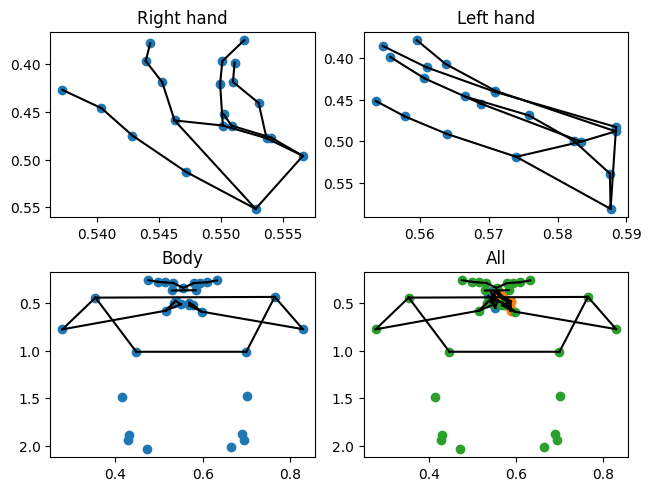

In [159]:
graph_drawer(pd.read_csv("hello/1/Frame_12.csv"), edges)

In [ ]:
animation_plot("hello/1",edges) 

# __Keypoint Folder__

In [34]:
def operate2(mp_holistic,holistic_model, mp_drawing, file,folder_path,index):
    vdo_path = os.path.join('VDO',folder_path, file)
    os.mkdir('Landmarked/' + folder_path+'/'+str(index))
    vid = cv2.VideoCapture(vdo_path)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper])
        hand_pos_df.to_csv('Landmarked/'+folder_path + '/' +str(index) +'/'+str(total_capture-1)+'.csv')
        # print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    # vid.release()
    # cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

In [35]:
def landmark_folder(folder_path):
    for word_folder in os.listdir(folder_path):
        if word_folder == '.DS_Store':
            continue
        print(f'กำลัง keypoint {word_folder}...')
        files = os.listdir(f'VDO/{word_folder}')
        os.mkdir('Landmarked/' + word_folder)
        for index,file in enumerate(files):
            operate2(mp_holistic,holistic_model, mp_drawing, file,word_folder,index)
    print("เสร็จหมดละจ้าา")

# __Using Zone__

In [39]:
"""
ให้ใส่ชื่อ Folder ที่ต้องการ landmark โดยมันจะไปอยู่ในโฟลเดอร์ Landmarked อีกที ให้สร้างด้วยนะจ๊ะ
พอได้ไฟล์แล้ว เอาไปใส่ในไดร์ฟ อย่าอัปขึน git ไม่งั้น บู้มมมมมมมมมมม 
"""
landmark_folder('VDO')

กำลัง keypoint หนังสือ...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ทารก...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint อยู่...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint อาหาร...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint พูด...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint คน...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ยินดีด้วย...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ผู้หญิง...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint วันอังคาร...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint วันเสาร์...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ต้นไม้...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ทำไม...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint อ่าน...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ฟัง...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ภาษามือไทย...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint กระโดด...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint จาน...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint วันศุกร์...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint แมว...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ดื่ม...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint คุณ...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ผลไม้...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint กลางคืน...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ช้อน...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ร้องไห้...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ตื่น...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ดอกไม้...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint ของขวัญ...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!
กำลัง keypoint คอมพิวเตอร์...


/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
/Users/theerat/sign-language-translator/.venv/lib/python3.9/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolData


Done!


ZeroDivisionError: integer division or modulo by zero

# Capture

In [17]:
stop_recording = False

def capture(word,count):
    global stop_recording
    webcam = cv2.VideoCapture(0)

    if not webcam.isOpened():
        print("ไม่สามารถเปิด webcam ได้")
        exit()

    frame_width = int(webcam.get(4))
    frame_height = int(webcam.get(4))

    fps = int(webcam.get(cv2.CAP_PROP_FPS))
    print(f"คำว่า : '{word}' ครั้งที่ {count}")
    # print("Webcam FPS:", fps)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(f"VDO/{word}/{word}_re_{count}.mp4", fourcc, fps, (frame_width, frame_height))

    while not stop_recording:
        ret, frame = webcam.read()

        if ret:
            frame = cv2.flip(frame, 1)
            pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_img)

            font_path = "SukhumvitSet-Medium.ttf"
            font = ImageFont.truetype(font_path, 120)
            font2 = ImageFont.truetype(font_path, 50)

            draw.text((50, 50), word, font=font, fill=(255, 255, 255))
            draw.text((50,200), f'คลิปที่ : {count}', font=font, fill=(255, 255, 255))
            draw.text((1500,50), 'กด q เมื่อบันทึกเสร็จ', font=font2, fill=(255, 255, 255))
            draw.text((1500,200), 'กด d เพื่อยกเลิก', font=font2, fill=(255, 255, 255))

            frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

            cv2.imshow("Webcam", frame)
            out.write(frame)

        if cv2.waitKey(100) & 0xFF == ord("q"):
            break

    webcam.release()
    out.release()
    cv2.destroyAllWindows()


In [18]:
def cap_sl(word):
    global stop_recording
    ex_vdo = cv2.VideoCapture(f'VDO/{word}/{word}_test.mp4')
    while True:
        ret, frame = ex_vdo.read()

        if not ret:
            print("ไม่สามารถอ่านไฟล์ได้")
            break

        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_img)

        font_path = "SukhumvitSet-Medium.ttf"
        font = ImageFont.truetype(font_path, 50)

        text_position = (50, 50)
        draw.text(text_position, word, font=font, fill=(255, 255, 255))

        frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        cv2.imshow('Example Video', frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    ex_vdo.release()
    cv2.destroyAllWindows()
    
    time.sleep(3)
    for i in range(1,30):
        capture(word,i)
        time.sleep(5)
        if cv2.waitKey(100) & 0xFF == ord('d'):
            stop_recording = True
            break
        
    print('เสร็จแล้ววว')

In [19]:
cap_sl('คอมพิวเตอร์')

ไม่สามารถอ่านไฟล์ได้
คำว่า : 'คอมพิวเตอร์' ครั้งที่ 1
คำว่า : 'คอมพิวเตอร์' ครั้งที่ 2
คำว่า : 'คอมพิวเตอร์' ครั้งที่ 3
เสร็จแล้ววว
